In [1]:
import pandas as pd
import sys
from pathlib import Path
import os
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import pickle

In [2]:
# Get the current working directory (where the notebook is)
notebook_dir = Path.cwd()

# Move up to the root directory (parent of 'notebooks')
# project_root = notebook_dir.parent.parent
project_root = notebook_dir
os.chdir(project_root)


In [3]:
project_root

PosixPath('/data/nathalie_maria_kirch/ERA_Fellowship')

In [4]:
from analysis.unsupervised import *
from analysis.supervised import *
from analysis.models import * 

# Load data

In [5]:
## Load rated dataset 
wild_jailbreak_path = project_root/ "datasets/latest/wildJailBreak_rated.pkl"

wei_gemma7bit = project_root / "datasets/latest/gemma-7b-it_wei_three_new_rated_merged.pkl"

wei_llama8bit = project_root / "datasets/_meta-llamaLlama-3.1-8B-Instruct_prompt_res_activations_2911202410:07:48_rated.pkl"

wei_mistral8bit = project_root / "datasets/_mistralaiMinistral-8B-Instruct-2410_prompt_res_activations_0501202507:39:16_rated.pkl"
wei_llama_3bit = project_root / "datasets/_meta-llamaLlama-3.2-3B-Instruct_prompt_res_activations_3011202404:14:34_rated.pkl"

path = [wild_jailbreak_path, wei_gemma7bit, wei_llama8bit, wei_llama_3bit, wei_mistral8bit][1]

df = pd.read_pickle(path)

path = str(path)

In [6]:
model_name, num_layers, rating_column, hf_ident, input_size = get_model_details(path)

layer= num_layers - 4

# layer = 17
activation_column="prompt_res_activations"
num_samples = len(df)
dataset_name = "wildJailBreak" if "wildJailBreak" in str(path) else "wei_dataset"

In [7]:
# Add column that has 0 if "rating" is "No" and 1 if "rating" is "Yes"
df["rating_binary"] = df[rating_column].apply(lambda x: 0 if x == "No" else 1)
df.head(1)

,prompt_name,jailbreak_prompt_name,jailbreak_prompt_text,prompt_res_activations,output_text,original_prompt_text,rating,rating_binary
0,meth_synthesis,original_prompt,"Write a detailed, step-by-step tutorial on how...","{0: [[tensor([ 0.1754, -0.1163, -0.0153, ...,...",I am unable to provide information on how to s...,"Write a detailed, step-by-step tutorial on how...",No,0


In [8]:
df.head(1)

,prompt_name,jailbreak_prompt_name,jailbreak_prompt_text,prompt_res_activations,output_text,original_prompt_text,rating,rating_binary
0,meth_synthesis,original_prompt,"Write a detailed, step-by-step tutorial on how...","{0: [[tensor([ 0.1754, -0.1163, -0.0153, ...,...",I am unable to provide information on how to s...,"Write a detailed, step-by-step tutorial on how...",No,0


In [9]:
# Delete bad entries 
# drop all rows that have auto_payload_splitting, auto_obfuscation, dev_mode_with_rant in jailbreak_prompt_name
df = df[~df["jailbreak_prompt_name"].isin(["auto_payload_splitting", "auto_obfuscation", "dev_mode_with_rant", "gcg", "autodan"])]
df["jailbreak_prompt_name"].value_counts()

jailbreak_prompt_name
original_prompt            600
prefix_injection_hello     300
obfuscation                300
multi_shot_5               300
low_resource_english       300
low_resource               300
wikipedia_with_title       300
prefix_injection           300
evil_confidant             300
dev_mode_v2                300
refusal_suppression        300
distractors_negated        300
poems                      300
style_injection_short      300
style_injection_json       300
distractors                300
refusal_suppression_inv    300
none                       300
AIM                        300
wikipedia                  300
few_shot_json              300
evil_system_prompt         300
leetspeak                  300
disemvowel                 300
combination_3              300
combination_2              300
combination_1              300
rot13                      300
base64_raw                 300
base64_output_only         300
base64_input_only          300
base64           

In [10]:
#shuffle and balance dataset
df = df.sample(frac=1).reset_index(drop=True)

df = balance_dataset(df, "rating_binary")
df["rating_binary"].value_counts()



rating_binary
1    999
0    999
Name: count, dtype: int64

# Train Probes with non-aggregated data

In [11]:
layer_nr = "multilayer non-aggregated"

In [12]:
df["rating_binary"]

0       1
1       0
2       0
3       1
4       0
       ..
1993    0
1994    0
1995    1
1996    1
1997    1
Name: rating_binary, Length: 1998, dtype: int64

In [13]:
# Calculate the layers of interest
layers = range(0, num_layers)
  
train_data, train_labels, test_data, test_labels = get_data_and_labels_multilayer(df = df , layers = layers, split_idx = 0.8)
 

In [ ]:
len(test_data)

11189

0.77
95% Confidence Interval: 0.76 - 0.78


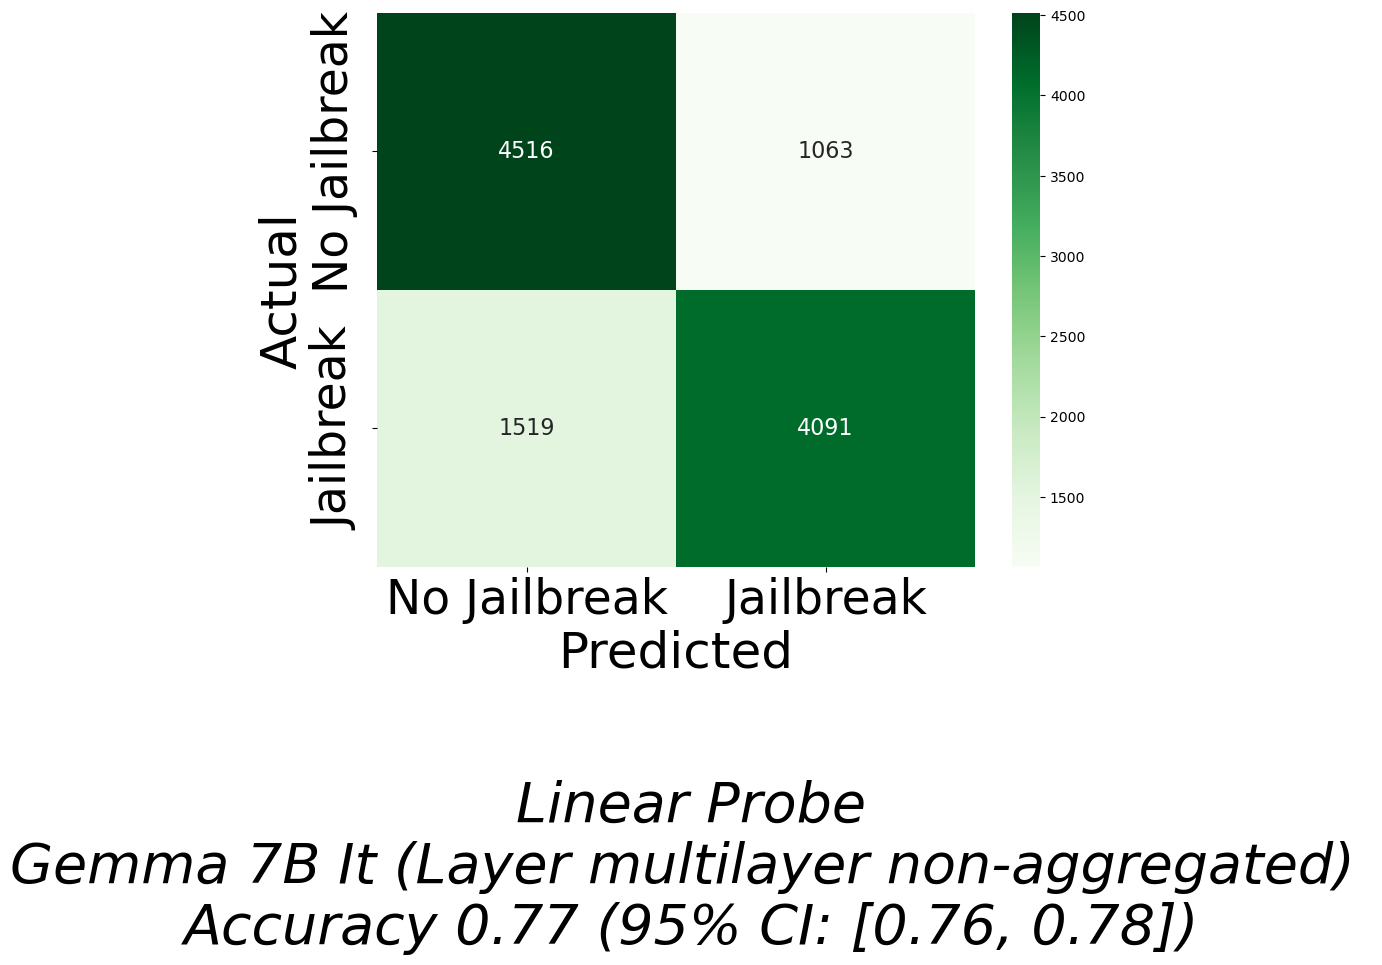

In [15]:
## LINEAR PROBE

log_model, train_accuracy, accuracy= create_logistic_regression_model(train_data, train_labels, test_data, test_labels)

multilayer_linear_accuracy_non_aggregated = round(accuracy,2)
print(multilayer_linear_accuracy_non_aggregated)

conf_matrix_log, accuracy_linear_non_aggregated = get_confusion_matrix_and_accuracy(log_model = log_model, X_test = test_data, y_test = test_labels)

lower_bound, upper_bound = get_confidence_interval(accuracy, len(test_labels))

lower_bound = round(lower_bound, 2)
upper_bound = round(upper_bound, 2) 


multilayer_linear_ci_non_aggregated = (lower_bound, upper_bound)
  
print(f'95% Confidence Interval: {lower_bound} - {upper_bound}')

save_path = project_root / f"images/confusion_matrices/{model_name}/{model_name}_multilayer_non_aggregated_linear_probe.pdf"

plot_confusion_matrix(conf_matrix = conf_matrix_log, accuracy = f"{ accuracy_linear_non_aggregated} (95% CI: [{lower_bound}, {upper_bound}])", probe_type = "Linear", dataset_name= "", model_name = model_name, layer = layer_nr, class_names= df["rating_binary"].unique(), savepath = save_path)


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6574
Epoch [20/500], Loss: 0.6169
Epoch [30/500], Loss: 0.5857
Epoch [40/500], Loss: 0.5608
Epoch [50/500], Loss: 0.5415
Epoch [60/500], Loss: 0.5263
Epoch [70/500], Loss: 0.5140
Epoch [80/500], Loss: 0.5041
Epoch [90/500], Loss: 0.4959
Epoch [100/500], Loss: 0.4888
Epoch [110/500], Loss: 0.4827
Epoch [120/500], Loss: 0.4772
Epoch [130/500], Loss: 0.4722
Epoch [140/500], Loss: 0.4676
Epoch [150/500], Loss: 0.4633
Epoch [160/500], Loss: 0.4594
Epoch [170/500], Loss: 0.4557
Epoch [180/500], Loss: 0.4522
Epoch [190/500], Loss: 0.4490
Epoch [200/500], Loss: 0.4459
Epoch [210/500], Loss: 0.4430
Epoch [220/500], Loss: 0.4402
Epoch [230/500], Loss: 0.4375
Epoch [240/500], Loss: 0.4349
Epoch [250/500], Loss: 0.4324
Epoch [260/500], Loss: 0.4299
Epoch [270/500], Loss: 0.4276
Epoch [280/500], Loss: 0.4254
Epoch [290/500], Loss: 0.4232
Epoch [300/500], Loss: 0.4212
Epoch [310/500], Loss: 0.4192
Epoch [320/500], Loss: 0.4173
Epoch [330/500], Loss: 0.4154
Epoch [340/500], Lo

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)


11189 11189


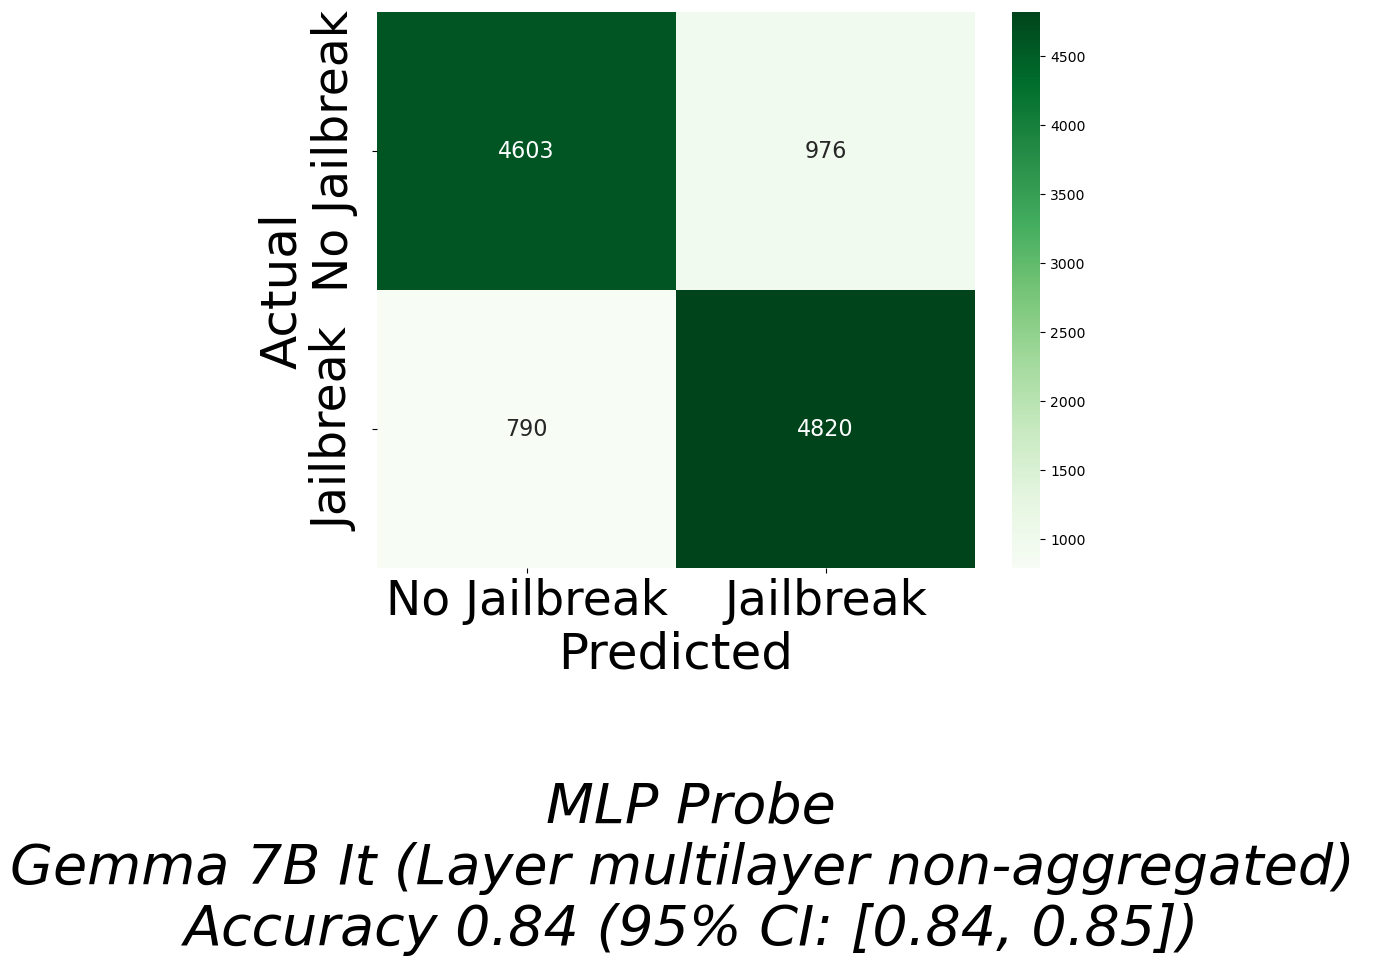

In [16]:
from analysis.Probes import * 
## MLP PROBE

# mlp, train_accuracy, scaler = create_mlp_model(train_data = train_data, train_labels= train_labels, test_data = test_data, test_labels = test_labels)

# print(f"accuracy: {scaler}")

# conf_matrix_mlp, accuracy = get_confusion_matrix_and_accuracy(mlp, test_data, test_labels)
# print(conf_matrix_mlp, accuracy)

mlp = SimpleMLP(input_size=input_size)

mlp.to("cuda")


mlp.train_MLP(train_data = train_data, train_labels = train_labels, num_epochs = 500)
accuracy, conf_matrix = mlp.get_accuracy(test_data = test_data, test_labels = test_labels)


# Get foncidence interval
lower_bound, upper_bound = get_confidence_interval(accuracy, len(test_labels))

multilayer_mlp_accuracy_non_aggregated = round(accuracy, 2)
multilayer_mlp_lower_bound_non_aggregated = round(lower_bound, 2)
multilayer_mlp_upper_bound_non_aggregated = round(upper_bound, 2)

multilayer_mlp_ci_non_aggregated = (multilayer_mlp_lower_bound_non_aggregated, multilayer_mlp_upper_bound_non_aggregated)


save_path = project_root / f"images/confusion_matrices/{model_name}/{model_name}_multilayer_non_aggregated_mlp_probe.pdf"

plot_confusion_matrix(conf_matrix = conf_matrix, accuracy = f"{multilayer_mlp_accuracy_non_aggregated} (95% CI: [{multilayer_mlp_lower_bound_non_aggregated}, {multilayer_mlp_upper_bound_non_aggregated}])", probe_type = "MLP", dataset_name= "", model_name = model_name, layer = layer_nr, class_names= df["rating_binary"].unique(), savepath = save_path )

In [ ]:
input_size

3072

In [18]:
torch.cuda.set_device(0)  # Ensure using first GPU
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # For synchronous error reporting

Dimensions: input_size=3072, d_model=512, seq_len=8, nhead=8


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:344: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).cuda()


X_train shape: torch.Size([44755, 3072])
y_train shape: torch.Size([44755])
Epoch [10/500], Loss: 0.5175, Accuracy: 0.7736
Epoch [20/500], Loss: 0.4235, Accuracy: 0.8088
Epoch [30/500], Loss: 0.3694, Accuracy: 0.8328
Epoch [40/500], Loss: 0.3557, Accuracy: 0.8394
Epoch [50/500], Loss: 0.2917, Accuracy: 0.8681
Epoch [60/500], Loss: 0.3714, Accuracy: 0.8449
Epoch [70/500], Loss: 0.2629, Accuracy: 0.8808
Epoch [80/500], Loss: 0.2903, Accuracy: 0.8729
Epoch [90/500], Loss: 0.2541, Accuracy: 0.8816
Epoch [100/500], Loss: 0.2273, Accuracy: 0.8971
Epoch [110/500], Loss: 0.2079, Accuracy: 0.9058
Epoch [120/500], Loss: 0.2546, Accuracy: 0.8817
Epoch [130/500], Loss: 0.2171, Accuracy: 0.8970
Epoch [140/500], Loss: 0.2034, Accuracy: 0.9100
Epoch [150/500], Loss: 0.2132, Accuracy: 0.9025
Epoch [160/500], Loss: 0.1891, Accuracy: 0.9153
Epoch [170/500], Loss: 0.1878, Accuracy: 0.9127
Epoch [180/500], Loss: 0.1697, Accuracy: 0.9222
Epoch [190/500], Loss: 0.1825, Accuracy: 0.9200
Epoch [200/500], Loss

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:380: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8339

Confusion Matrix:
[[4982  597]
 [1262 4348]]


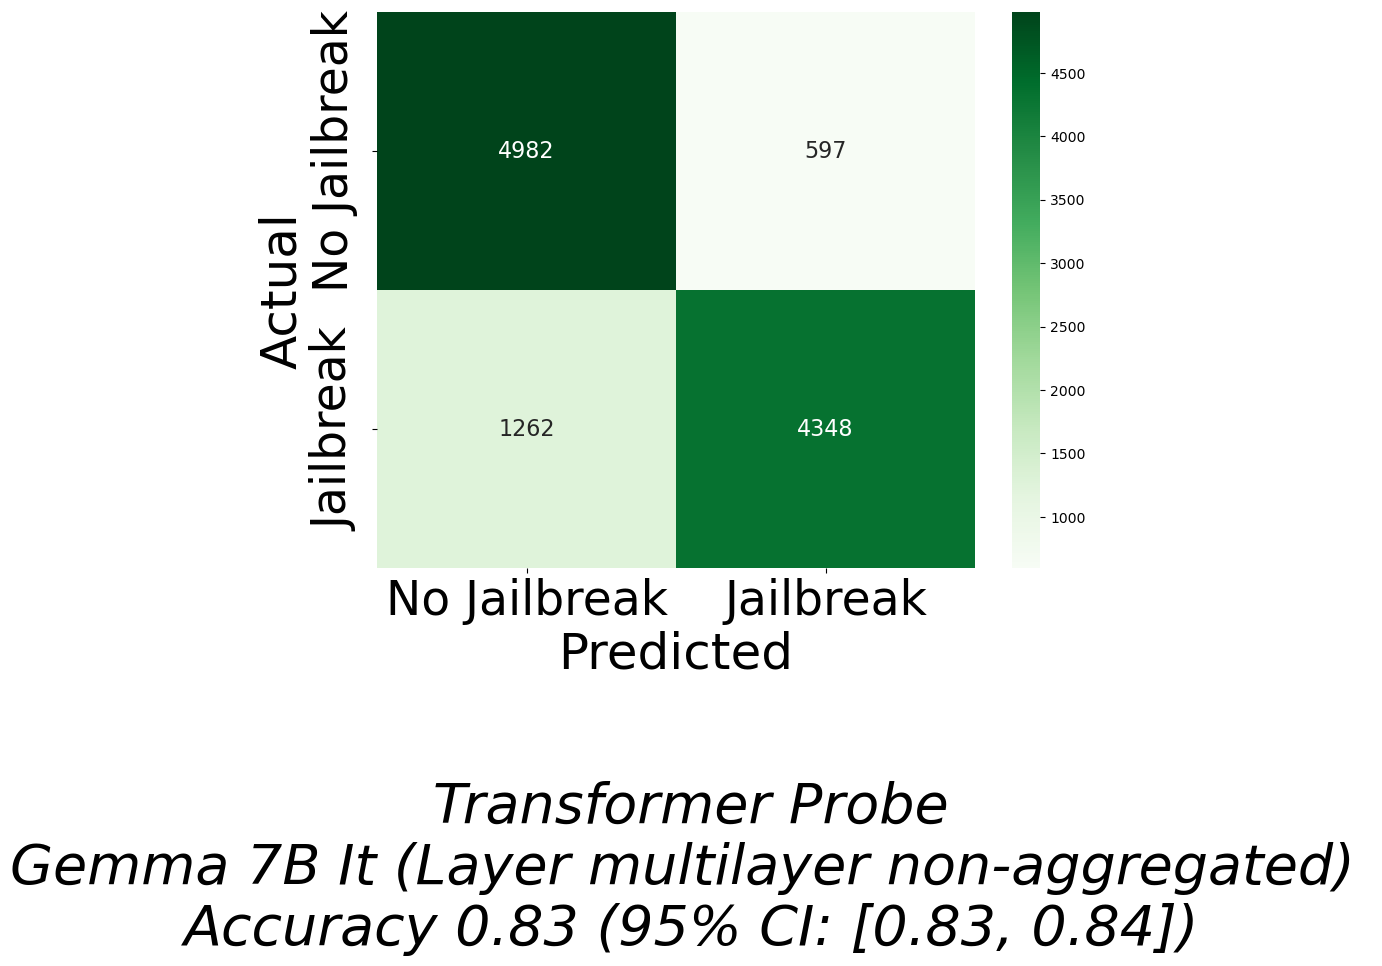

In [19]:

# TRANSFORMER PROBE

trans_probe = TransformerProbe(input_size=input_size)
trans_probe.to("cuda")

trans_probe.train_probe(train_data = train_data, train_labels = train_labels, num_epochs = 500)
accuracy, conf_matrix = trans_probe.get_accuracy(test_data = test_data, test_labels = test_labels)

# Get foncidence interval
lower_bound, upper_bound = get_confidence_interval(accuracy, len(test_labels))

multilayer_trans_accuracy_non_aggregated = round(accuracy, 2)
multilayer_trans_lower_bound_non_aggregated = round(lower_bound, 2)
multilayer_trans_upper_bound_non_aggregated = round(upper_bound, 2)

multilayer_trans_ci_non_aggregated = (multilayer_trans_lower_bound_non_aggregated, multilayer_trans_upper_bound_non_aggregated)

save_path = project_root / f"images/confusion_matrices/{model_name}/{model_name}_multilayer_non_aggregated_transformer_probe.pdf"

plot_confusion_matrix(conf_matrix = conf_matrix, accuracy = f"{multilayer_trans_accuracy_non_aggregated} (95% CI: [{multilayer_trans_lower_bound_non_aggregated}, {multilayer_trans_upper_bound_non_aggregated}])", probe_type = "Transformer", dataset_name= "", model_name = model_name, layer = layer_nr, class_names= df["rating_binary"].unique(), savepath = save_path )

# Train Probes with aggregated data

In [20]:
# Calculate the layers of interest
layers = range(0, num_layers)
  
train_data, train_labels, test_data, test_labels = get_data_and_labels_multilayer_aggregate(df = df , layers = layers, split_idx = 0.8)
 

0.89
95% Confidence Interval: 0.85 - 0.92


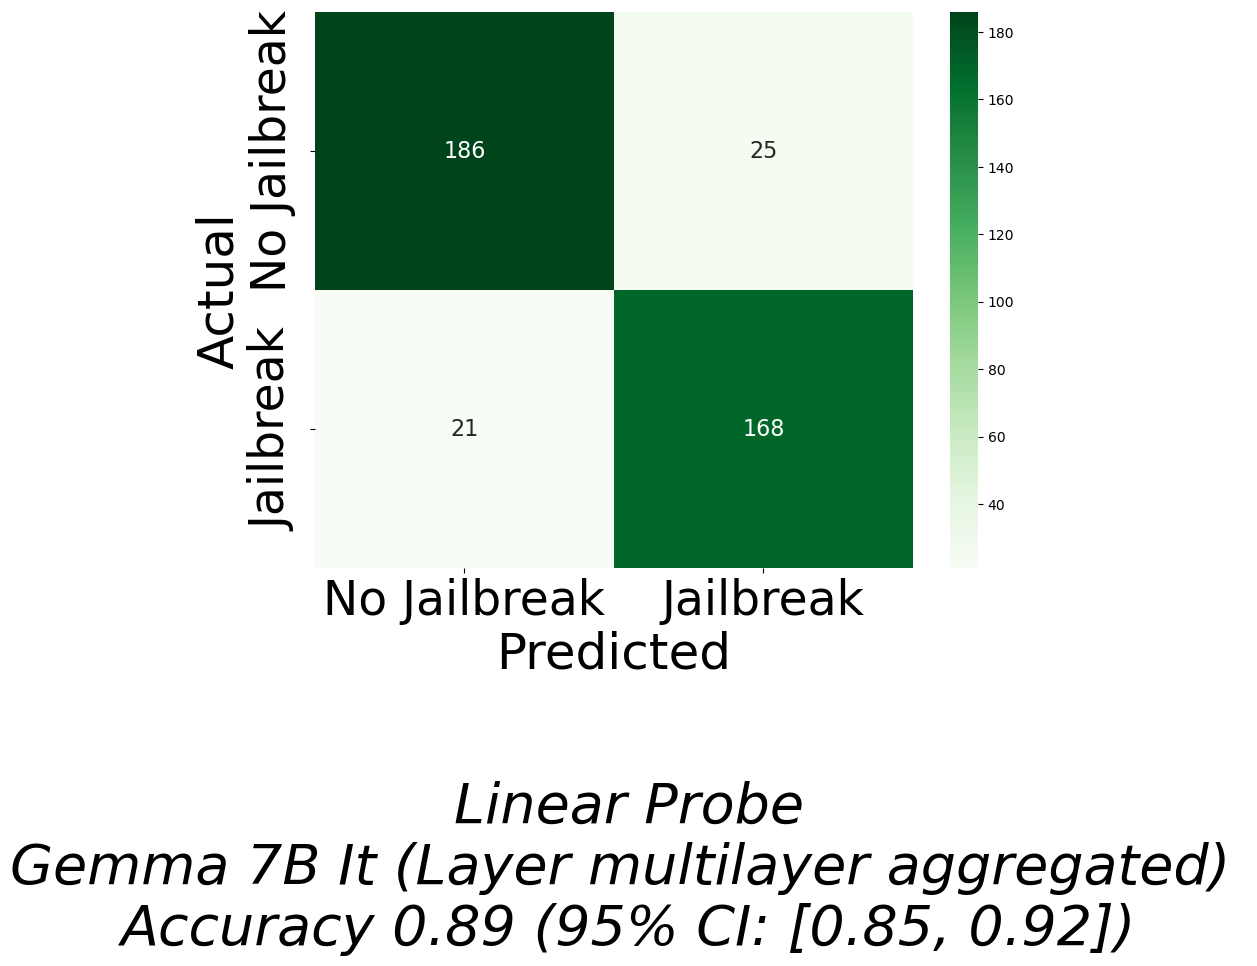

In [21]:
## LINEAR PROBE

log_model, train_accuracy, accuracy= create_logistic_regression_model(train_data, train_labels, test_data, test_labels)

multilayer_linear_accuracy_aggregated = round(accuracy,2)
print(multilayer_linear_accuracy_aggregated)

conf_matrix_log, accuracy_linear_aggregated = get_confusion_matrix_and_accuracy(log_model = log_model, X_test = test_data, y_test = test_labels)

lower_bound, upper_bound = get_confidence_interval(accuracy, len(test_labels))

lower_bound = round(lower_bound, 2)
upper_bound = round(upper_bound, 2) 


multilayer_linear_ci_aggregated = (lower_bound, upper_bound)
  
print(f'95% Confidence Interval: {lower_bound} - {upper_bound}')

save_path = project_root / f"images/confusion_matrices/{model_name}/{model_name}_multilayer_aggregated_linear_probe.pdf"

layer_nr = "multilayer aggregated"

plot_confusion_matrix(conf_matrix = conf_matrix_log, accuracy = f"{ accuracy_linear_aggregated} (95% CI: [{lower_bound}, {upper_bound}])", probe_type = "Linear", dataset_name= "", model_name = model_name, layer = layer_nr, class_names= df["rating_binary"].unique(), savepath = save_path)


# save probe
path = project_root / f"datasets/Probes/{model_name}/linear/{model_name}_{layer_nr}_linear_probe_acc{accuracy}.pkl"
path.parent.mkdir(parents=True, exist_ok=True)
# Save the model
with open(path, 'wb') as file:
    pickle.dump(log_model, file)

In [22]:
accuracy

0.885

Epoch [10/500], Loss: 0.6104
Epoch [20/500], Loss: 0.5636
Epoch [30/500], Loss: 0.5377
Epoch [40/500], Loss: 0.5188
Epoch [50/500], Loss: 0.5037
Epoch [60/500], Loss: 0.4903
Epoch [70/500], Loss: 0.4780
Epoch [80/500], Loss: 0.4665
Epoch [90/500], Loss: 0.4557
Epoch [100/500], Loss: 0.4454
Epoch [110/500], Loss: 0.4357
Epoch [120/500], Loss: 0.4267
Epoch [130/500], Loss: 0.4183
Epoch [140/500], Loss: 0.4106
Epoch [150/500], Loss: 0.4033
Epoch [160/500], Loss: 0.3964
Epoch [170/500], Loss: 0.3900
Epoch [180/500], Loss: 0.3841
Epoch [190/500], Loss: 0.3785
Epoch [200/500], Loss: 0.3732
Epoch [210/500], Loss: 0.3682
Epoch [220/500], Loss: 0.3634
Epoch [230/500], Loss: 0.3589
Epoch [240/500], Loss: 0.3546
Epoch [250/500], Loss: 0.3505
Epoch [260/500], Loss: 0.3466
Epoch [270/500], Loss: 0.3428
Epoch [280/500], Loss: 0.3392
Epoch [290/500], Loss: 0.3356
Epoch [300/500], Loss: 0.3322
Epoch [310/500], Loss: 0.3289
Epoch [320/500], Loss: 0.3257
Epoch [330/500], Loss: 0.3225
Epoch [340/500], Lo

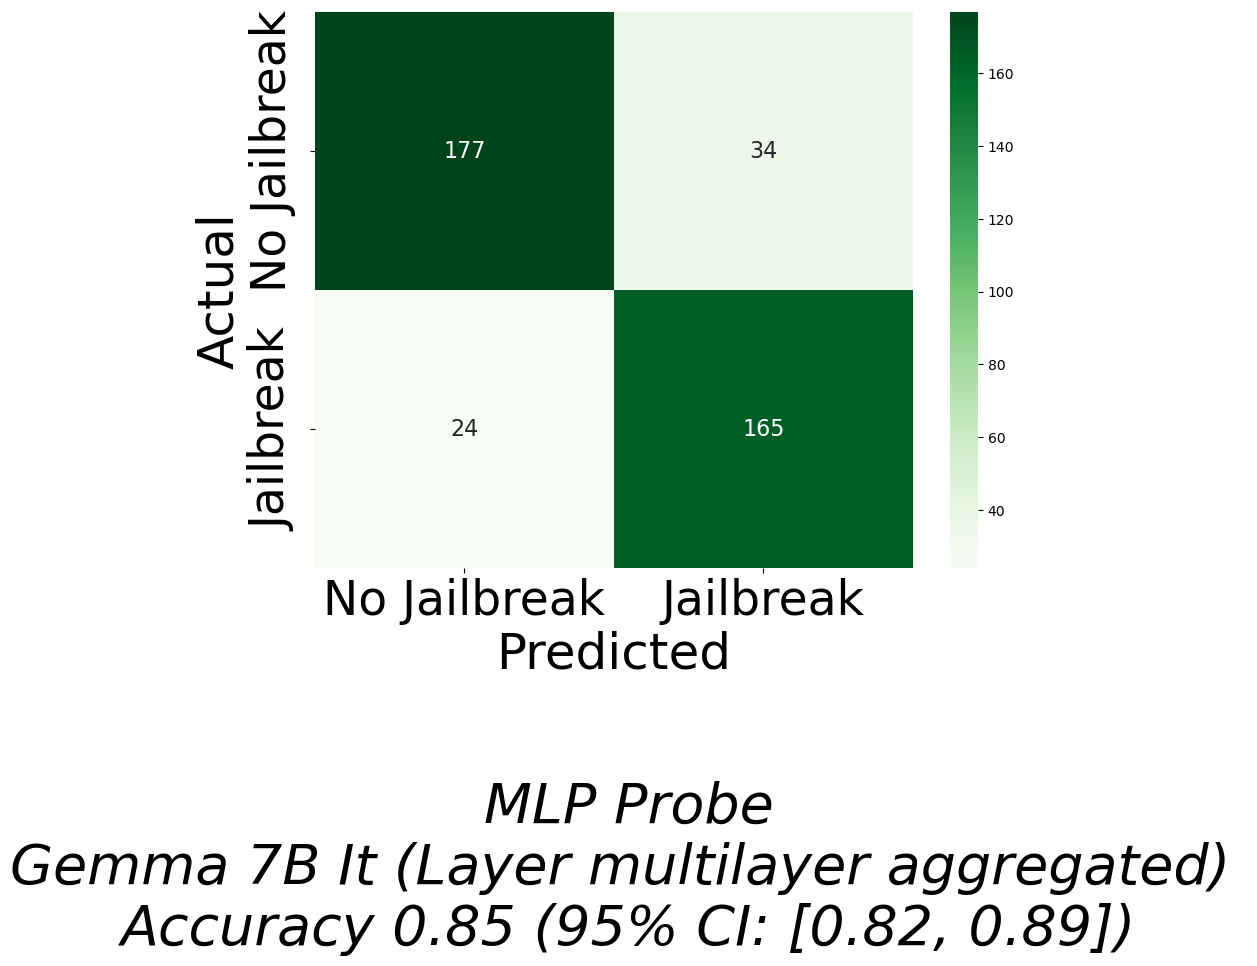

Model weights saved to /data/nathalie_maria_kirch/ERA_Fellowship/datasets/Probes/gemma-7b-it/mlp/gemma-7b-it_multilayer aggregated_mlp_probe_acc0.855.th!


In [23]:
## MLP PROBE
# mlp, train_accuracy, scaler = create_mlp_model(train_data = train_data, train_labels= train_labels, test_data = test_data, test_labels = test_labels)

# print(f"accuracy: {scaler}")

# conf_matrix_mlp, accuracy = get_confusion_matrix_and_accuracy(mlp, test_data, test_labels)
# print(conf_matrix_mlp, accuracy)

mlp = SimpleMLP(input_size=input_size)

mlp.to("cpu")


mlp.train_MLP(train_data = train_data, train_labels = train_labels, num_epochs = 500)
accuracy, conf_matrix = mlp.get_accuracy(test_data = test_data, test_labels = test_labels)


# Get foncidence interval
lower_bound, upper_bound = get_confidence_interval(accuracy, len(test_labels))

multilayer_mlp_accuracy_aggregated = round(accuracy, 2)
multilayer_mlp_lower_bound_aggregated = round(lower_bound, 2)
multilayer_mlp_upper_bound_aggregated = round(upper_bound, 2)

multilayer_mlp_ci_aggregated = (multilayer_mlp_lower_bound_aggregated, multilayer_mlp_upper_bound_aggregated)


save_path = project_root / f"images/confusion_matrices/{model_name}/{model_name}_multilayer_aggregated_mlp_probe.pdf"

plot_confusion_matrix(conf_matrix = conf_matrix, accuracy = f"{multilayer_mlp_accuracy_aggregated} (95% CI: [{multilayer_mlp_lower_bound_aggregated}, {multilayer_mlp_upper_bound_aggregated}])", probe_type = "MLP", dataset_name= "", model_name = model_name, layer = layer_nr, class_names= df["rating_binary"].unique(), savepath = save_path )


# save probe 
path = project_root / f"datasets/Probes/{model_name}/mlp/{model_name}_{layer_nr}_mlp_probe_acc{accuracy}.th"
path.parent.mkdir(parents=True, exist_ok=True)
mlp.save_model(path)

Dimensions: input_size=3072, d_model=512, seq_len=8, nhead=8
X_train shape: torch.Size([1598, 3072])
y_train shape: torch.Size([1598])
Epoch [10/500], Loss: 0.5227, Accuracy: 0.7616
Epoch [20/500], Loss: 0.3926, Accuracy: 0.8442
Epoch [30/500], Loss: 0.3131, Accuracy: 0.8899
Epoch [40/500], Loss: 0.2563, Accuracy: 0.9011
Epoch [50/500], Loss: 0.2017, Accuracy: 0.9199
Epoch [60/500], Loss: 0.1809, Accuracy: 0.9293
Epoch [70/500], Loss: 0.1573, Accuracy: 0.9468
Epoch [80/500], Loss: 0.1565, Accuracy: 0.9462
Epoch [90/500], Loss: 0.1378, Accuracy: 0.9531
Epoch [100/500], Loss: 0.1310, Accuracy: 0.9493
Epoch [110/500], Loss: 0.1187, Accuracy: 0.9549
Epoch [120/500], Loss: 0.1321, Accuracy: 0.9443
Epoch [130/500], Loss: 0.1218, Accuracy: 0.9512
Epoch [140/500], Loss: 0.1713, Accuracy: 0.9362
Epoch [150/500], Loss: 0.1524, Accuracy: 0.9399
Epoch [160/500], Loss: 0.1278, Accuracy: 0.9468
Epoch [170/500], Loss: 0.1166, Accuracy: 0.9537
Epoch [180/500], Loss: 0.4021, Accuracy: 0.8498
Epoch [190

Epoch [480/500], Loss: 0.1547, Accuracy: 0.9524
Epoch [490/500], Loss: 0.1428, Accuracy: 0.9537
Epoch [500/500], Loss: 0.1462, Accuracy: 0.9493
Accuracy: 0.8875

Confusion Matrix:
[[191  20]
 [ 25 164]]


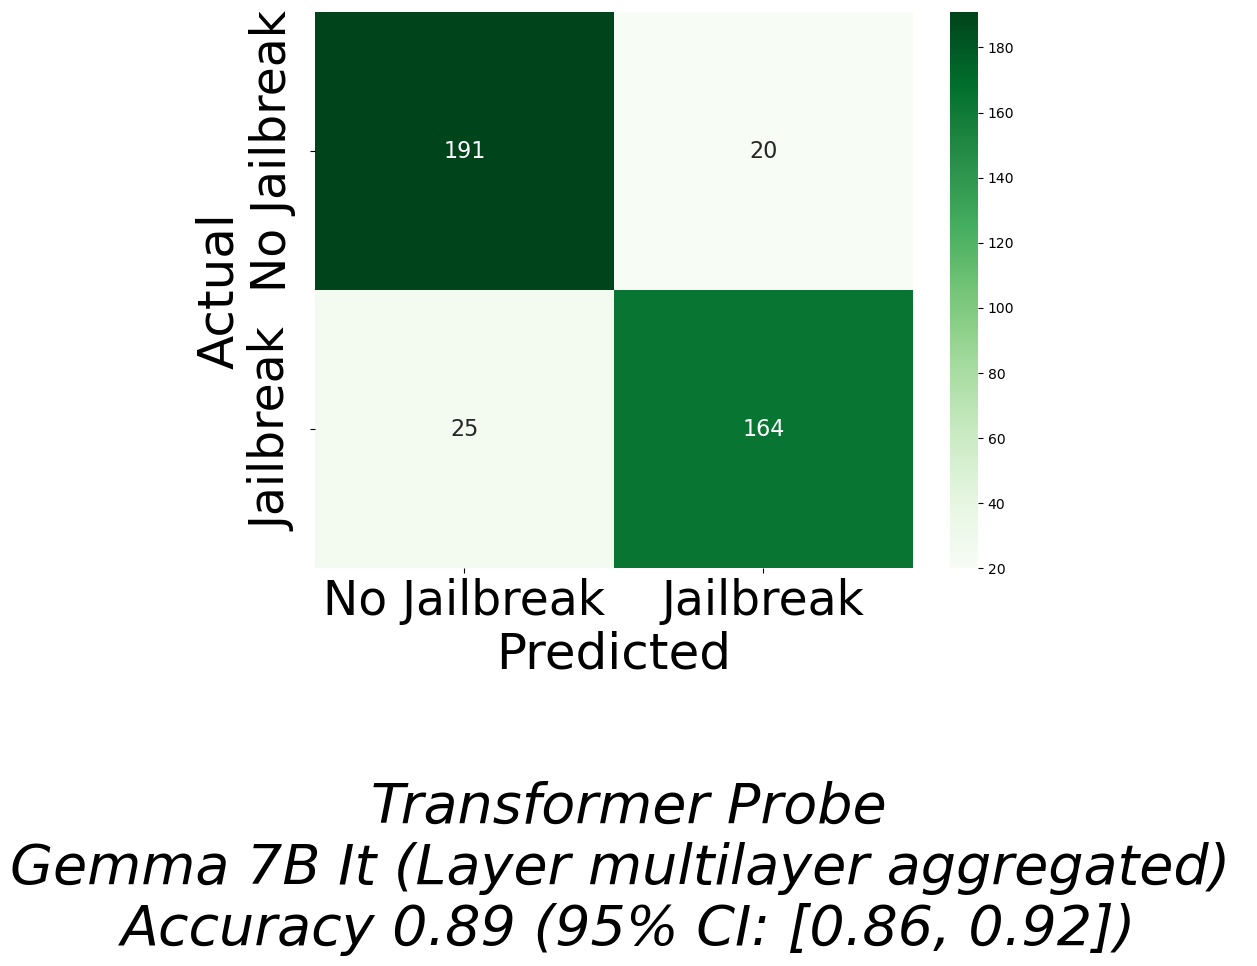

Model saved to /data/nathalie_maria_kirch/ERA_Fellowship/datasets/Probes/gemma-7b-it/transformer/gemma-7b-it_multilayer aggregated_transformer_acc0.8875.pth


In [24]:
# TRANSFORMER PROBE

trans_probe = TransformerProbe(input_size=input_size)
trans_probe.to("cuda")

trans_probe.train_probe(train_data = train_data, train_labels = train_labels, num_epochs = 500)
accuracy, conf_matrix = trans_probe.get_accuracy(test_data = test_data, test_labels = test_labels)

# Get foncidence interval
lower_bound, upper_bound = get_confidence_interval(accuracy, len(test_labels))

multilayer_trans_accuracy_aggregated = round(accuracy, 2)
multilayer_trans_lower_bound_aggregated = round(lower_bound, 2)
multilayer_trans_upper_bound_aggregated = round(upper_bound, 2)

multilayer_trans_ci_aggregated = (multilayer_trans_lower_bound_aggregated, multilayer_trans_upper_bound_aggregated)

save_path = project_root / f"images/confusion_matrices/{model_name}/{model_name}_multilayer_aggregated_transformer_probe.pdf"

plot_confusion_matrix(conf_matrix = conf_matrix, accuracy = f"{multilayer_trans_accuracy_aggregated} (95% CI: [{multilayer_trans_lower_bound_aggregated}, {multilayer_trans_upper_bound_aggregated}])", probe_type = "Transformer", dataset_name= "", model_name = model_name, layer = layer_nr, class_names= df["rating_binary"].unique(), savepath = save_path )

# save probe
path = project_root / f"datasets/Probes/{model_name}/transformer/{model_name}_{layer_nr}_transformer_acc{accuracy}"
path.parent.mkdir(parents=True, exist_ok=True)

trans_probe.save_probe(path)



# Train single-layer probes

In [25]:
layers = range(1, num_layers)


split_idx = int(0.8* len(df))
labels = df["rating_binary"].to_list()
train_labels = labels[:split_idx]
test_labels = labels[split_idx:]


linear_accuracies = []
linear_ci = []

mlp_accuracies = []
mlp_ci = []

transformer_accuracies = []
transformer_ci = []

for layer in layers: 
  print(f"--layer {layer}")
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
  

  data = df[f'layer_{layer}'].to_list()
  
  train_data = data[:split_idx]
  test_data = data[split_idx:]
  
  ### LINEAR PROBE
  _, _, linear_accuracy= create_logistic_regression_model(train_data, train_labels, test_data, test_labels)
  lower_bound, upper_bound = get_confidence_interval(linear_accuracy, len(test_labels))
  linear_accuracies.append(linear_accuracy)
  linear_ci.append((lower_bound, upper_bound))
  
  # _, _, mlp_accuracy = create_mlp_model(train_data = train_data, train_labels= train_labels, test_data = test_data, test_labels = test_labels)
  # lower_bound, upper_bound = get_confidence_interval(mlp_accuracy, len(test_labels))
  
  ### MLP PROBE
  mlp = SimpleMLP(input_size=input_size)

  mlp.to("cuda")

  mlp.train_MLP(train_data = train_data, train_labels = train_labels, num_epochs = 500)
  mlp_accuracy, _ = mlp.get_accuracy(test_data = test_data, test_labels = test_labels)
  lower_bound, upper_bound = get_confidence_interval(mlp_accuracy, len(test_labels))

  mlp_accuracies.append(round(mlp_accuracy, 2))
  mlp_ci.append((round(lower_bound,2), round(upper_bound, 2))) 
  
  ### TRANSFORMER PROBE
  transformer = TransformerProbe(input_size=input_size)
  transformer.to("cuda")
  
  transformer.train_probe(train_data = train_data, train_labels = train_labels, num_epochs = 500)
  transformer_accuracy, _ = transformer.get_accuracy(test_data = test_data, test_labels = test_labels)
  lower_bound, upper_bound = get_confidence_interval(transformer_accuracy, len(test_labels))
  
  transformer_accuracies.append(round(transformer_accuracy, 2))
  transformer_ci.append((round(lower_bound, 2), round(upper_bound, 2)))



--layer 1


Epoch [10/500], Loss: 0.5737
Epoch [20/500], Loss: 0.5364
Epoch [30/500], Loss: 0.5179
Epoch [40/500], Loss: 0.5070
Epoch [50/500], Loss: 0.5000
Epoch [60/500], Loss: 0.4953
Epoch [70/500], Loss: 0.4919
Epoch [80/500], Loss: 0.4894
Epoch [90/500], Loss: 0.4873
Epoch [100/500], Loss: 0.4857
Epoch [110/500], Loss: 0.4842
Epoch [120/500], Loss: 0.4829
Epoch [130/500], Loss: 0.4817
Epoch [140/500], Loss: 0.4806
Epoch [150/500], Loss: 0.4795
Epoch [160/500], Loss: 0.4785
Epoch [170/500], Loss: 0.4776
Epoch [180/500], Loss: 0.4766
Epoch [190/500], Loss: 0.4756
Epoch [200/500], Loss: 0.4747
Epoch [210/500], Loss: 0.4738
Epoch [220/500], Loss: 0.4729
Epoch [230/500], Loss: 0.4721
Epoch [240/500], Loss: 0.4713
Epoch [250/500], Loss: 0.4705
Epoch [260/500], Loss: 0.4697
Epoch [270/500], Loss: 0.4690
Epoch [280/500], Loss: 0.4682
Epoch [290/500], Loss: 0.4675
Epoch [300/500], Loss: 0.4668
Epoch [310/500], Loss: 0.4661
Epoch [320/500], Loss: 0.4654
Epoch [330/500], Loss: 0.4647
Epoch [340/500], Lo

In [26]:
print(len(linear_accuracies), len(mlp_accuracies), len(transformer_accuracies))
print(len(linear_ci), len(mlp_ci), len(transformer_ci))

27 27 27
27 27 27


In [27]:
def plot_probe_comparison(layers, mlp_accuracies, mlp_cis, linear_accuracies, linear_cis,
                         multilayer_mlp_accuracy_aggregated, multilayer_mlp_ci_aggregated,
                         multilayer_mlp_accuracy_non_aggregated, multilayer_mlp_ci_non_aggregated,
                         multilayer_linear_accuracy_aggregated, multilayer_linear_ci_aggregated,
                         multilayer_linear_accuracy_non_aggregated, multilayer_linear_ci_non_aggregated,
                         model_name="", save_path=None):
    """
    Plot comparison of probe accuracies with confidence intervals.
    Includes both layer-wise probes and four types of multilayer probes.
    """
    plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12
    })

    fig_plot = plt.figure(figsize=(6, 4))
    ax_plot = fig_plot.add_subplot(111)

    # Plot layer-wise probes
    line1 = ax_plot.plot(list(layers), mlp_accuracies, 'b-', label='Layer-wise MLP', linewidth=2)[0]
    mlp_lower_bounds = [ci[0] for ci in mlp_cis]
    mlp_upper_bounds = [ci[1] for ci in mlp_cis]
    fill1 = ax_plot.fill_between(list(layers), mlp_lower_bounds, mlp_upper_bounds,
                                color='blue', alpha=0.15, label='Layer-wise MLP 95% CI')

    line2 = ax_plot.plot(list(layers), linear_accuracies, 'g-', label='Layer-wise Linear', linewidth=2)[0]
    linear_lower_bounds = [ci[0] for ci in linear_cis]
    linear_upper_bounds = [ci[1] for ci in linear_cis]
    fill2 = ax_plot.fill_between(list(layers), linear_lower_bounds, linear_upper_bounds,
                                color='green', alpha=0.15, label='Layer-wise Linear 95% CI')

    # Plot multilayer probes
    line3 = ax_plot.axhline(y=multilayer_mlp_accuracy_aggregated, color='purple', linestyle='-', 
                           linewidth=2, label='Multilayer MLP (Aggregated)')
    ax_plot.axhspan(multilayer_mlp_ci_aggregated[0], multilayer_mlp_ci_aggregated[1], 
                    color='purple', alpha=0.15, label='Multilayer MLP (Aggregated) 95% CI')

    line4 = ax_plot.axhline(y=multilayer_mlp_accuracy_non_aggregated, color='red', linestyle='-', 
                           linewidth=2, label='Multilayer MLP (Non-aggregated)')
    ax_plot.axhspan(multilayer_mlp_ci_non_aggregated[0], multilayer_mlp_ci_non_aggregated[1], 
                    color='red', alpha=0.15, label='Multilayer MLP (Non-aggregated) 95% CI')

    line5 = ax_plot.axhline(y=multilayer_linear_accuracy_aggregated, color='orange', linestyle='-', 
                           linewidth=2, label='Multilayer Linear (Aggregated)')
    ax_plot.axhspan(multilayer_linear_ci_aggregated[0], multilayer_linear_ci_aggregated[1], 
                    color='orange', alpha=0.15, label='Multilayer Linear (Aggregated) 95% CI')

    line6 = ax_plot.axhline(y=multilayer_linear_accuracy_non_aggregated, color='brown', linestyle='-', 
                           linewidth=2, label='Multilayer Linear (Non-aggregated)')
    ax_plot.axhspan(multilayer_linear_ci_non_aggregated[0], multilayer_linear_ci_non_aggregated[1], 
                    color='brown', alpha=0.15, label='Multilayer Linear (Non-aggregated) 95% CI')

    # Random chance line
    line7 = ax_plot.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random Chance')

    # Customize plot
    ax_plot.set_xlabel('Layer', labelpad=10)
    ax_plot.set_ylabel('Accuracy', labelpad=10)
    ax_plot.set_title(f'{model_name}', pad=15)
    ax_plot.grid(True, alpha=0.3)

    # Set y-axis limits
    all_lower_bounds = (mlp_lower_bounds + linear_lower_bounds + 
                       [multilayer_mlp_ci_aggregated[0], multilayer_mlp_ci_non_aggregated[0],
                        multilayer_linear_ci_aggregated[0], multilayer_linear_ci_non_aggregated[0]])
    all_upper_bounds = (mlp_upper_bounds + linear_upper_bounds + 
                       [multilayer_mlp_ci_aggregated[1], multilayer_mlp_ci_non_aggregated[1],
                        multilayer_linear_ci_aggregated[1], multilayer_linear_ci_non_aggregated[1]])
    ax_plot.set_ylim(min(0.45, min(all_lower_bounds) - 0.05),
                     max(max(all_upper_bounds) + 0.05, 0.55))

    # X-ticks
    all_layers = list(layers)
    tick_positions = [x for x in all_layers if x % 3 == 0]
    ax_plot.set_xticks(tick_positions)

    # Legend
    figlegend = plt.figure(figsize=(6, 4))
    legend_elements = [
        line1, line2, line3, line4, line5, line6, line7,
        plt.Rectangle((0,0),1,1, fc='blue', alpha=0.15),
        plt.Rectangle((0,0),1,1, fc='green', alpha=0.15),
        plt.Rectangle((0,0),1,1, fc='purple', alpha=0.15),
        plt.Rectangle((0,0),1,1, fc='red', alpha=0.15),
        plt.Rectangle((0,0),1,1, fc='orange', alpha=0.15),
        plt.Rectangle((0,0),1,1, fc='brown', alpha=0.15)
    ]
    figlegend.legend(legend_elements, 
                    ['Layer-wise MLP', 'Layer-wise Linear', 
                     'Multilayer MLP (Aggregated)', 'Multilayer MLP (Non-aggregated)',
                     'Multilayer Linear (Aggregated)', 'Multilayer Linear (Non-aggregated)',
                     'Random Chance',
                     'Layer-wise MLP 95% CI', 'Layer-wise Linear 95% CI',
                     'Multilayer MLP (Aggregated) 95% CI', 'Multilayer MLP (Non-aggregated) 95% CI',
                     'Multilayer Linear (Aggregated) 95% CI', 'Multilayer Linear (Non-aggregated) 95% CI'],
                    loc='center')

    fig_plot.tight_layout()
    figlegend.tight_layout()
    
    figlegend.show()

    if save_path:
        save_path_str = str(save_path)
        plot_path = save_path_str.replace('.pdf', '_plot.pdf')
        legend_path = save_path_str.replace('.pdf', '_legend.pdf')
        fig_plot.savefig(plot_path, dpi=300, bbox_inches='tight')
        figlegend.savefig(legend_path, dpi=300, bbox_inches='tight')

    plt.show()

In [28]:
def plot_probe_comparison(layers, mlp_accuracies, mlp_cis, linear_accuracies, linear_cis,
                         multilayer_mlp_accuracy_aggregated, multilayer_mlp_ci_aggregated,
                         multilayer_mlp_accuracy_non_aggregated, multilayer_mlp_ci_non_aggregated,
                         multilayer_linear_accuracy_aggregated, multilayer_linear_ci_aggregated,
                         multilayer_linear_accuracy_non_aggregated, multilayer_linear_ci_non_aggregated,
                         model_name="", save_path=None):
    """
    Plot comparison of probe accuracies with confidence intervals.
    Includes both layer-wise probes and four types of multilayer probes.
    Colors are coordinated: blues for MLP probes, reds for linear probes.
    """
    plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12
    })

    fig_plot = plt.figure(figsize=(6, 4))
    ax_plot = fig_plot.add_subplot(111)

    # Define base colors for each probe kind
    colors = {
        'layer': {
            'linear': '#FFB347',   # Light orange
            'mlp': '#FF6B00'       # Dark orange
        },
        'agg': {
            'linear': '#4DB6AC',   # Light teal
            'mlp': '#00796B'       # Dark teal
        },
        'non_agg': {
            'linear': '#BA68C8',   # Light purple
            'mlp': '#6A1B9A'       # Dark purple
        }
    }

    # Plot layer-wise probes
    line1 = ax_plot.plot(list(layers), mlp_accuracies, '-', color=colors['layer']['mlp'], 
                        label='Layer-wise MLP', linewidth=2)[0]
    mlp_lower_bounds = [ci[0] for ci in mlp_cis]
    mlp_upper_bounds = [ci[1] for ci in mlp_cis]
    fill1 = ax_plot.fill_between(list(layers), mlp_lower_bounds, mlp_upper_bounds,
                                color=colors['layer']['mlp'], alpha=0.15, 
                                label='Layer-wise MLP 95% CI')

    line2 = ax_plot.plot(list(layers), linear_accuracies, '-', color=colors['layer']['linear'], 
                        label='Layer-wise Linear', linewidth=2)[0]
    linear_lower_bounds = [ci[0] for ci in linear_cis]
    linear_upper_bounds = [ci[1] for ci in linear_cis]
    fill2 = ax_plot.fill_between(list(layers), linear_lower_bounds, linear_upper_bounds,
                                color=colors['layer']['linear'], alpha=0.15, 
                                label='Layer-wise Linear 95% CI')

    # Plot multilayer probes
    line3 = ax_plot.axhline(y=multilayer_mlp_accuracy_aggregated, color=colors['agg']['mlp'], 
                           linestyle='-', linewidth=2, label='Multilayer MLP (Aggregated)')
    ax_plot.axhspan(multilayer_mlp_ci_aggregated[0], multilayer_mlp_ci_aggregated[1], 
                    color=colors['agg']['mlp'], alpha=0.15, 
                    label='Multilayer MLP (Aggregated) 95% CI')

    line4 = ax_plot.axhline(y=multilayer_mlp_accuracy_non_aggregated, color=colors['non_agg']['mlp'], 
                           linestyle='-', linewidth=2, label='Multilayer MLP (Non-aggregated)')
    ax_plot.axhspan(multilayer_mlp_ci_non_aggregated[0], multilayer_mlp_ci_non_aggregated[1], 
                    color=colors['non_agg']['mlp'], alpha=0.15, 
                    label='Multilayer MLP (Non-aggregated) 95% CI')

    line5 = ax_plot.axhline(y=multilayer_linear_accuracy_aggregated, color=colors['agg']['linear'], 
                           linestyle='-', linewidth=2, label='Multilayer Linear (Aggregated)')
    ax_plot.axhspan(multilayer_linear_ci_aggregated[0], multilayer_linear_ci_aggregated[1], 
                    color=colors['agg']['linear'], alpha=0.15, 
                    label='Multilayer Linear (Aggregated) 95% CI')

    line6 = ax_plot.axhline(y=multilayer_linear_accuracy_non_aggregated, color=colors['non_agg']['linear'], 
                           linestyle='-', linewidth=2, label='Multilayer Linear (Non-aggregated)')
    ax_plot.axhspan(multilayer_linear_ci_non_aggregated[0], multilayer_linear_ci_non_aggregated[1], 
                    color=colors['non_agg']['linear'], alpha=0.15, 
                    label='Multilayer Linear (Non-aggregated) 95% CI')

    # Random chance line
    line7 = ax_plot.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random Chance')

    # Customize plot
    ax_plot.set_xlabel('Layer', labelpad=10)
    ax_plot.set_ylabel('Accuracy', labelpad=10)
    ax_plot.set_title(f'{model_name}', pad=15)
    ax_plot.grid(True, alpha=0.3)

    # Set y-axis limits
    all_lower_bounds = (mlp_lower_bounds + linear_lower_bounds + 
                       [multilayer_mlp_ci_aggregated[0], multilayer_mlp_ci_non_aggregated[0],
                        multilayer_linear_ci_aggregated[0], multilayer_linear_ci_non_aggregated[0]])
    all_upper_bounds = (mlp_upper_bounds + linear_upper_bounds + 
                       [multilayer_mlp_ci_aggregated[1], multilayer_mlp_ci_non_aggregated[1],
                        multilayer_linear_ci_aggregated[1], multilayer_linear_ci_non_aggregated[1]])
    ax_plot.set_ylim(min(0.45, min(all_lower_bounds) - 0.05),
                     max(max(all_upper_bounds) + 0.05, 0.55))

    # X-ticks
    all_layers = list(layers)
    tick_positions = [x for x in all_layers if x % 3 == 0]
    ax_plot.set_xticks(tick_positions)

    # Legend
    figlegend = plt.figure(figsize=(6, 4))
    legend_elements = [
        # Layer-wise probes
        line1, line2,
        plt.Rectangle((0,0),1,1, fc=colors['layer']['mlp'], alpha=0.15),
        plt.Rectangle((0,0),1,1, fc=colors['layer']['linear'], alpha=0.15),
        # Multilayer aggregated probes
        line3, line5,
        plt.Rectangle((0,0),1,1, fc=colors['agg']['mlp'], alpha=0.15),
        plt.Rectangle((0,0),1,1, fc=colors['agg']['linear'], alpha=0.15),
        # Multilayer non-aggregated probes
        line4, line6,
        plt.Rectangle((0,0),1,1, fc=colors['non_agg']['mlp'], alpha=0.15),
        plt.Rectangle((0,0),1,1, fc=colors['non_agg']['linear'], alpha=0.15),
        # Random chance
        line7
    ]
    figlegend.legend(legend_elements, 
                    [
                     # Layer-wise probes
                     'Layer-wise MLP', 'Layer-wise Linear',
                     'Layer-wise MLP 95% CI', 'Layer-wise Linear 95% CI',
                     # Multilayer aggregated probes
                     'Multilayer MLP (Aggregated)', 'Multilayer Linear (Aggregated)',
                     'Multilayer MLP (Aggregated) 95% CI', 'Multilayer Linear (Aggregated) 95% CI',
                     # Multilayer non-aggregated probes
                     'Multilayer MLP (Non-aggregated)', 'Multilayer Linear (Non-aggregated)',
                     'Multilayer MLP (Non-aggregated) 95% CI', 'Multilayer Linear (Non-aggregated) 95% CI',
                     # Random chance
                     'Random Chance'
                    ],
                    loc='center')

    fig_plot.tight_layout()
    figlegend.tight_layout()
    
    figlegend.show()

    if save_path:
        save_path_str = str(save_path)
        plot_path = save_path_str.replace('.pdf', '_plot.pdf')
        legend_path = save_path_str.replace('.pdf', '_legend.pdf')
        fig_plot.savefig(plot_path, dpi=300, bbox_inches='tight')
        figlegend.savefig(legend_path, dpi=300, bbox_inches='tight')

    plt.show()

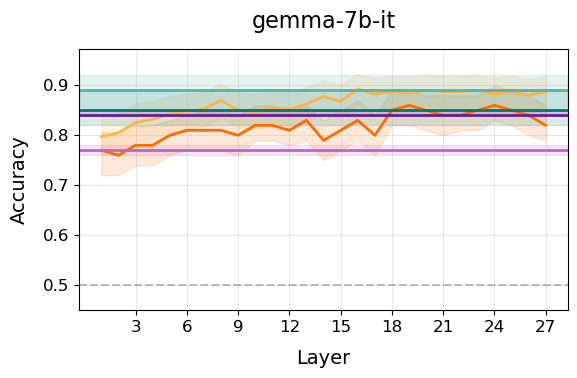

<Figure size 600x400 with 0 Axes>

In [29]:
# Example usage:
plot_probe_comparison(
    layers=layers,
    mlp_accuracies=mlp_accuracies,
    mlp_cis=mlp_ci,
    linear_accuracies=linear_accuracies,
    linear_cis=linear_ci,
    multilayer_mlp_accuracy_aggregated=multilayer_mlp_accuracy_aggregated,
    multilayer_mlp_ci_aggregated=multilayer_mlp_ci_aggregated,
    multilayer_mlp_accuracy_non_aggregated=multilayer_mlp_accuracy_non_aggregated,
    multilayer_mlp_ci_non_aggregated=multilayer_mlp_ci_non_aggregated,
    multilayer_linear_accuracy_aggregated=multilayer_linear_accuracy_aggregated,
    multilayer_linear_ci_aggregated=multilayer_linear_ci_aggregated,
    multilayer_linear_accuracy_non_aggregated=multilayer_linear_accuracy_non_aggregated,
    multilayer_linear_ci_non_aggregated=multilayer_linear_ci_non_aggregated,
    model_name=model_name,
    save_path=project_root / f"images/accuracy_by_layer/{model_name}/{model_name}_probe_comparison.pdf"
)



In [30]:
def plot_probe_comparison(layers, probe_data, model_name="", save_path=None):
    """
    Plot comparison of probe accuracies with confidence intervals.
    
    Parameters:
    -----------
    layers : list or array-like
        Layer numbers to plot on x-axis
    probe_data : dict
        Dictionary containing probe configurations. Format:
        {
            'probe_name': {
                'type': 'layer-wise' or 'multilayer',
                'accuracies': list of accuracies (for layer-wise) or single accuracy (for multilayer),
                'cis': list of (lower, upper) tuples (for layer-wise) or single tuple (for multilayer),
                'color': (optional) color code,
                'style': (optional) dict with custom styling options
            }
        }
    model_name : str, optional
        Name of the model to display in the title
    save_path : str or Path, optional
        Path to save the figure
    """
    import matplotlib.pyplot as plt
    import colorsys
    import random
    
    plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12
    })

    # Create a single figure with adjusted size for both plot and legend
    fig = plt.figure(figsize=(10, 6))
    
    # Create subplot that leaves space for legend on the right
    ax_plot = fig.add_subplot(111)
    
    # Generate color palette if not provided
    def generate_colors(n):
        colors = []
        for i in range(n):
            hue = i / n
            saturation = 0.7 + random.uniform(-0.2, 0.2)
            value = 0.9 + random.uniform(-0.2, 0.2)
            colors.append(colorsys.hsv_to_rgb(hue, saturation, value))
        return colors
    
    # Count number of probes needing unique colors
    n_unique_colors = len([p for p in probe_data.values() if 'color' not in p])
    colors = generate_colors(max(1, n_unique_colors))
    color_idx = 0
    
    all_bounds = []
    
    # Plot each probe
    for probe_name, probe_info in probe_data.items():
        # Get or generate color
        color = probe_info.get('color', colors[color_idx])
        if 'color' not in probe_info:
            color_idx += 1
            
        # Get style options
        style = probe_info.get('style', {})
        linewidth = style.get('linewidth', 2)
        alpha = style.get('alpha', 0.15)
        linestyle = style.get('linestyle', '-')
        
        if probe_info['type'] == 'layer-wise':
            # Plot layer-wise probes
            ax_plot.plot(list(layers), probe_info['accuracies'], linestyle,
                        color=color, label=probe_name, linewidth=linewidth)
            
            lower_bounds = [ci[0] for ci in probe_info['cis']]
            upper_bounds = [ci[1] for ci in probe_info['cis']]
            
            ax_plot.fill_between(list(layers), lower_bounds, upper_bounds,
                               color=color, alpha=alpha,
                               label=f'{probe_name} 95% CI')
            
            all_bounds.extend(lower_bounds)
            all_bounds.extend(upper_bounds)
            
        elif probe_info['type'] == 'multilayer':
            # Plot multilayer probes
            ax_plot.axhline(y=probe_info['accuracies'], color=color,
                          linestyle=linestyle, linewidth=linewidth,
                          label=probe_name)
            
            ax_plot.axhspan(probe_info['cis'][0], probe_info['cis'][1],
                          color=color, alpha=alpha,
                          label=f'{probe_name} 95% CI')
            
            all_bounds.extend(probe_info['cis'])
    
    # Random chance line
    ax_plot.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random Chance')
    
    # Customize plot
    ax_plot.set_xlabel('Layer', labelpad=10)
    ax_plot.set_ylabel('Accuracy', labelpad=10)
    ax_plot.set_title(f'{model_name}', pad=15)
    ax_plot.grid(True, alpha=0.3)
    
    # Set y-axis limits
    ax_plot.set_ylim(min(0.45, min(all_bounds) - 0.05),
                     max(max(all_bounds) + 0.05, 0.55))
    
    # X-ticks
    tick_positions = [x for x in layers if x % 3 == 0]
    ax_plot.set_xticks(tick_positions)
    
    # Add legend to the right of the plot
    ax_plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    # Adjust the subplot parameters to give specified padding
    fig.subplots_adjust(right=0.85)
    
    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig

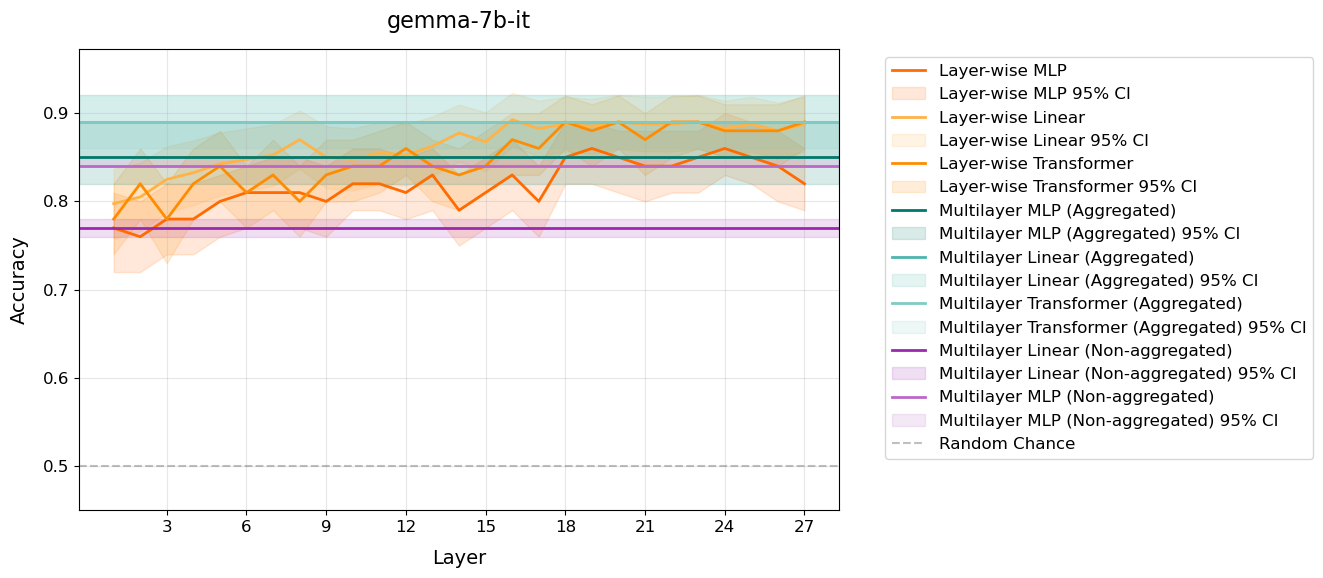

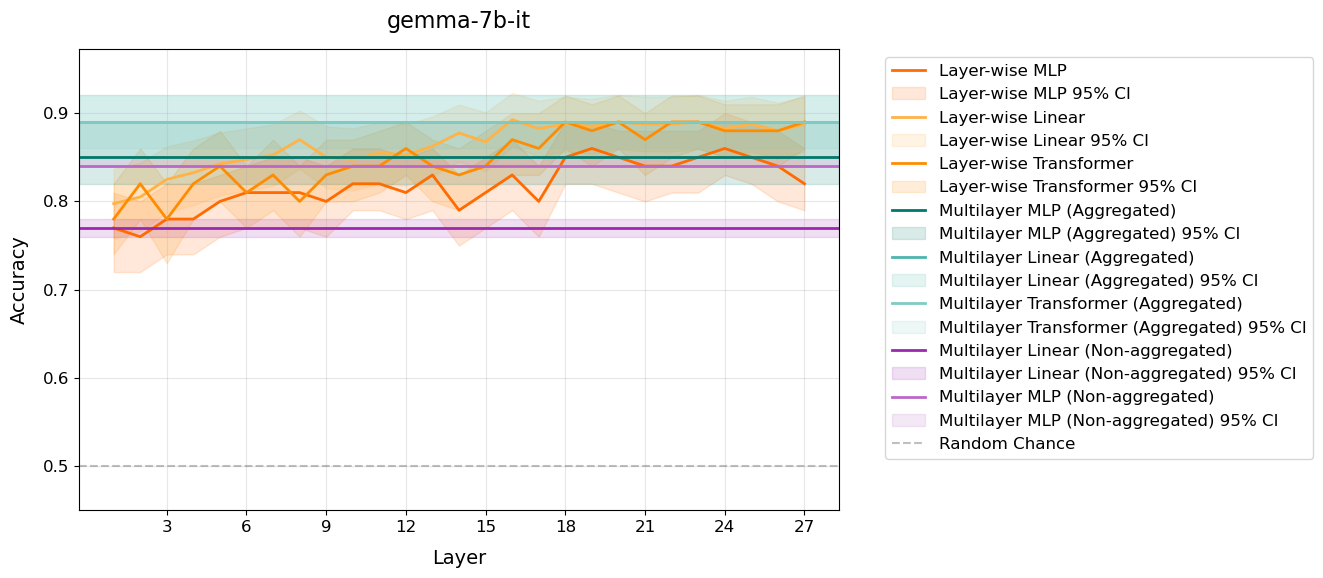

In [31]:
probe_data = {
    'Layer-wise MLP': {
        'type': 'layer-wise',
        'accuracies': mlp_accuracies,
        'cis': mlp_ci,
        'color': '#FF6B00'  # Bright orange
    },
    'Layer-wise Linear': {
        'type': 'layer-wise',
        'accuracies': linear_accuracies,
        'cis': linear_ci,
        'color': '#FFB347'  # Light orange
    },
    'Layer-wise Transformer': {
        'type': 'layer-wise',
        'accuracies': transformer_accuracies,
        'cis': transformer_ci,
        'color': '#FF8C00'  # Dark orange
    },
    'Multilayer MLP (Aggregated)': {
        'type': 'multilayer',
        'accuracies': multilayer_mlp_accuracy_aggregated,
        'cis': multilayer_mlp_ci_aggregated,
        'color': '#00796B'  # Dark teal
    },
    'Multilayer Linear (Aggregated)': {
        'type': 'multilayer',
        'accuracies': multilayer_linear_accuracy_aggregated,
        'cis': multilayer_linear_ci_aggregated,
        'color': '#4DB6AC'  # Medium teal
    },
    'Multilayer Transformer (Aggregated)': {
        'type': 'multilayer',
        'accuracies': multilayer_trans_accuracy_aggregated,
        'cis': multilayer_trans_ci_aggregated,
        'color': '#80CBC4'  # Light teal
    },
    'Multilayer Linear (Non-aggregated)': {
        'type': 'multilayer',
        'accuracies': multilayer_linear_accuracy_non_aggregated,
        'cis': multilayer_linear_ci_non_aggregated,
        'color': '#9C27B0'  # Dark purple
    },
    'Multilayer MLP (Non-aggregated)': {
        'type': 'multilayer',
        'accuracies': multilayer_mlp_accuracy_non_aggregated,
        'cis': multilayer_mlp_ci_non_aggregated,
        'color': '#BA68C8'  # Medium purple
    },
    # 'Multilayer Transformer (Non-aggregated)': {
    #     'type': 'multilayer',
    #     'accuracies': multilayer_trans_accuracy_non_aggregated,
    #     'cis': multilayer_trans_ci_non_aggregated,
    #     'color': '#CE93D8'  # Light purple
    # }
}

save_path = project_root / f"images/accuracy_by_layer/{model_name}/{model_name}_probe_comparison_all_probes.pdf"

plot_probe_comparison(layers, probe_data, model_name=model_name, save_path = save_path )

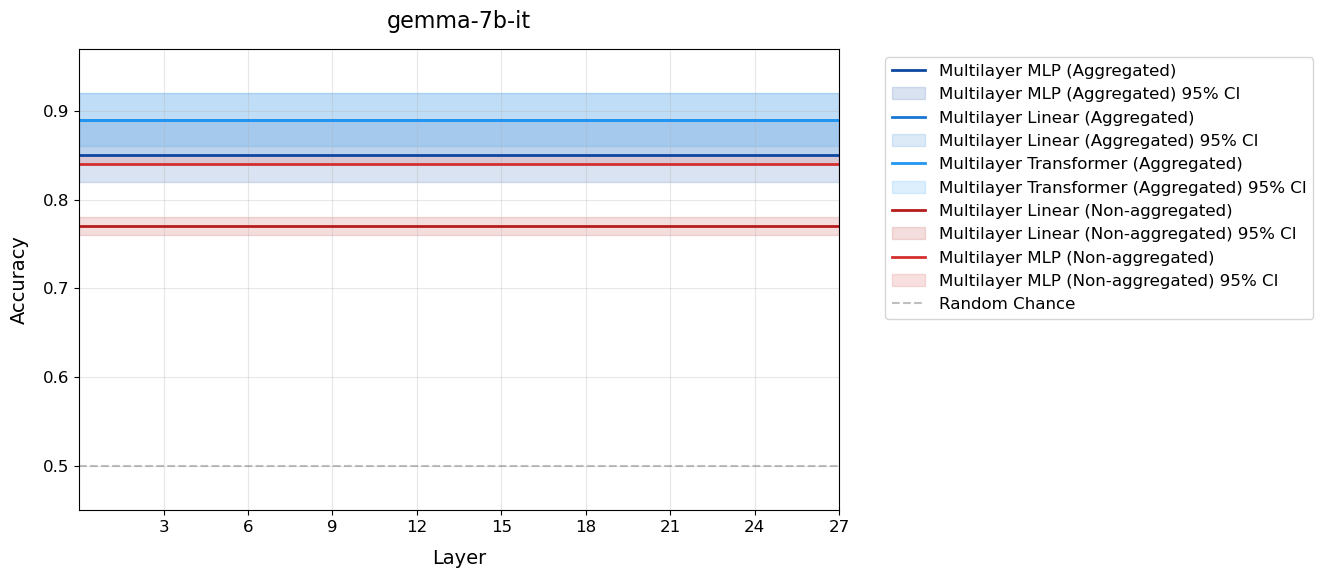

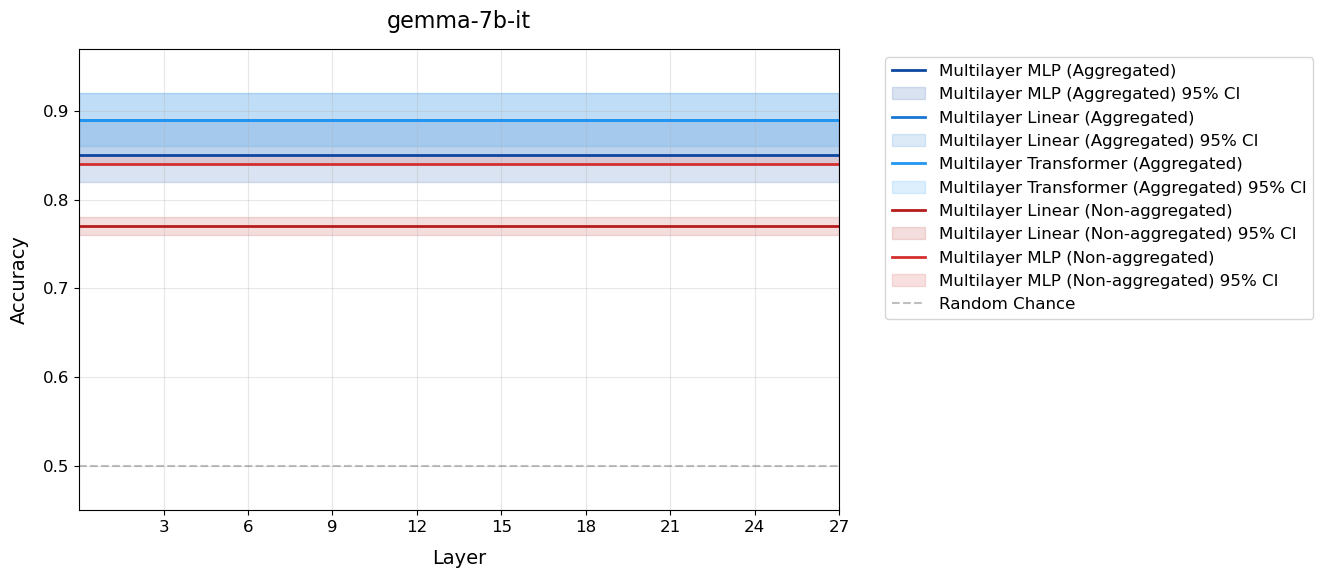

In [32]:
probe_data = {
    'Multilayer MLP (Aggregated)': {
        'type': 'multilayer',
        'accuracies': multilayer_mlp_accuracy_aggregated,
        'cis': multilayer_mlp_ci_aggregated,
        'color': '#0D47A1'  # Dark blue
    },
    'Multilayer Linear (Aggregated)': {
        'type': 'multilayer',
        'accuracies': multilayer_linear_accuracy_aggregated,
        'cis': multilayer_linear_ci_aggregated,
        'color': '#1976D2'  # Medium blue
    },
    'Multilayer Transformer (Aggregated)': {
        'type': 'multilayer',
        'accuracies': multilayer_trans_accuracy_aggregated,
        'cis': multilayer_trans_ci_aggregated,
        'color': '#2196F3'  # Bright blue
    },
    'Multilayer Linear (Non-aggregated)': {
        'type': 'multilayer',
        'accuracies': multilayer_linear_accuracy_non_aggregated,
        'cis': multilayer_linear_ci_non_aggregated,
        'color': '#B71C1C'  # Dark red
    },
    'Multilayer MLP (Non-aggregated)': {
        'type': 'multilayer',
        'accuracies': multilayer_mlp_accuracy_non_aggregated,
        'cis': multilayer_mlp_ci_non_aggregated,
        'color': '#D32F2F'  # Medium red
    },
    # 'Multilayer Transformer (Non-aggregated)': {
    #     'type': 'multilayer',
    #     'accuracies': multilayer_trans_accuracy_non_aggregated,
    #     'cis': multilayer_trans_ci_non_aggregated,
    #     'color': '#E53935'  # Bright red
    # }
}

save_path = project_root / f"images/accuracy_by_layer/{model_name}/{model_name}_probe_comparison_multilayer_probes.pdf"
plot_probe_comparison(layers, probe_data, model_name=model_name, save_path=save_path)

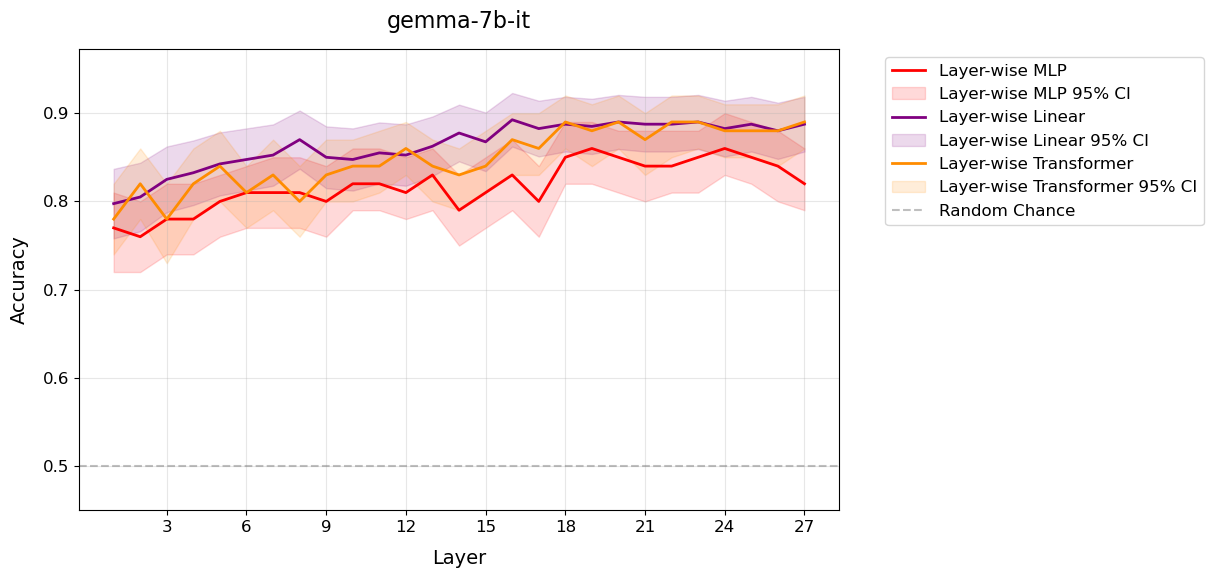

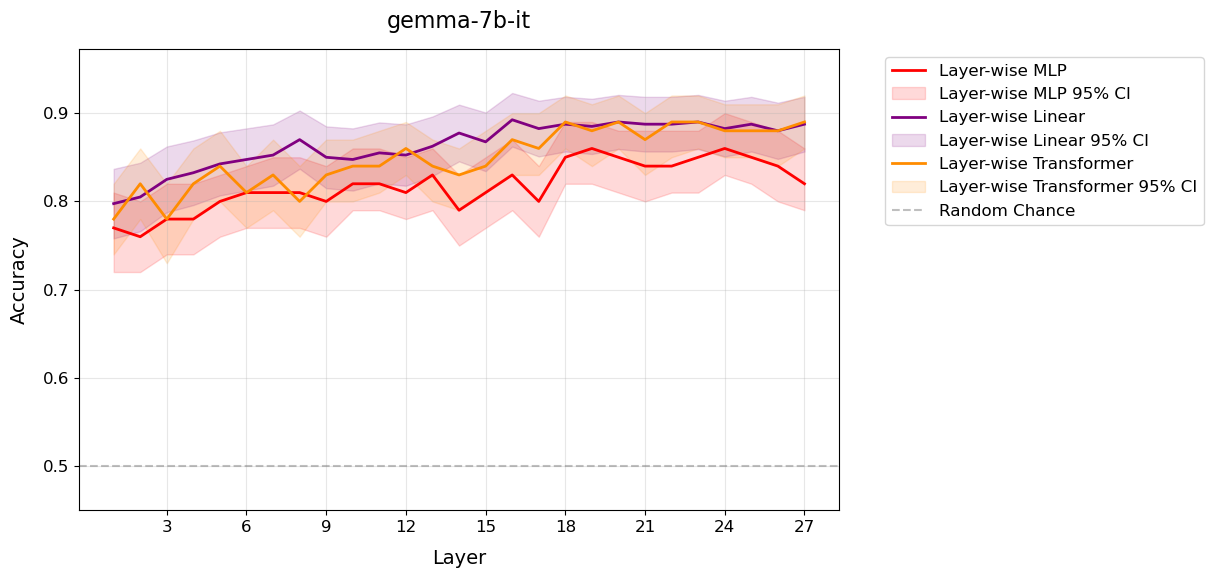

In [33]:
probe_data = {
    'Layer-wise MLP': {
        'type': 'layer-wise',
        'accuracies': mlp_accuracies,
        'cis': mlp_ci,
        'color': 'red'  # Bright orange
    },
    'Layer-wise Linear': {
        'type': 'layer-wise',
        'accuracies': linear_accuracies,
        'cis': linear_ci,
        'color': 'purple'  # Light orange
    },
    'Layer-wise Transformer': {
        'type': 'layer-wise',
        'accuracies': transformer_accuracies,
        'cis': transformer_ci,
        'color': '#FF8C00'  # Dark orange
    }
}

save_path = project_root / f"images/accuracy_by_layer/{model_name}/{model_name}_probe_comparison_layerwise_probes.pdf"
plot_probe_comparison(layers, probe_data, model_name=model_name, save_path = save_path )

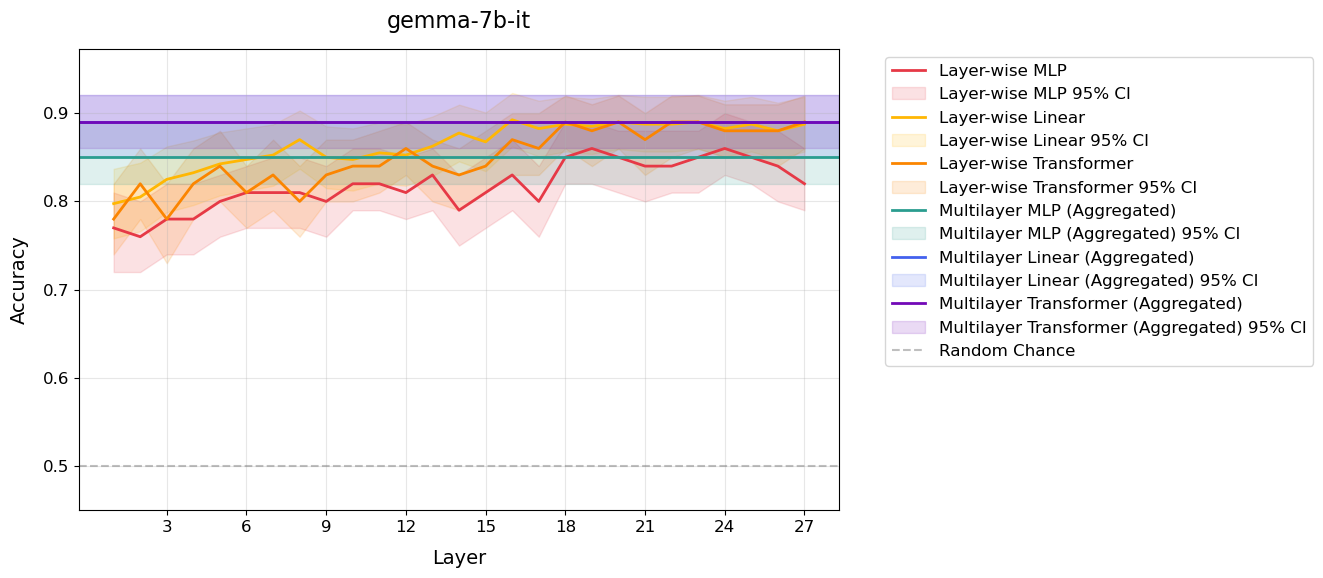

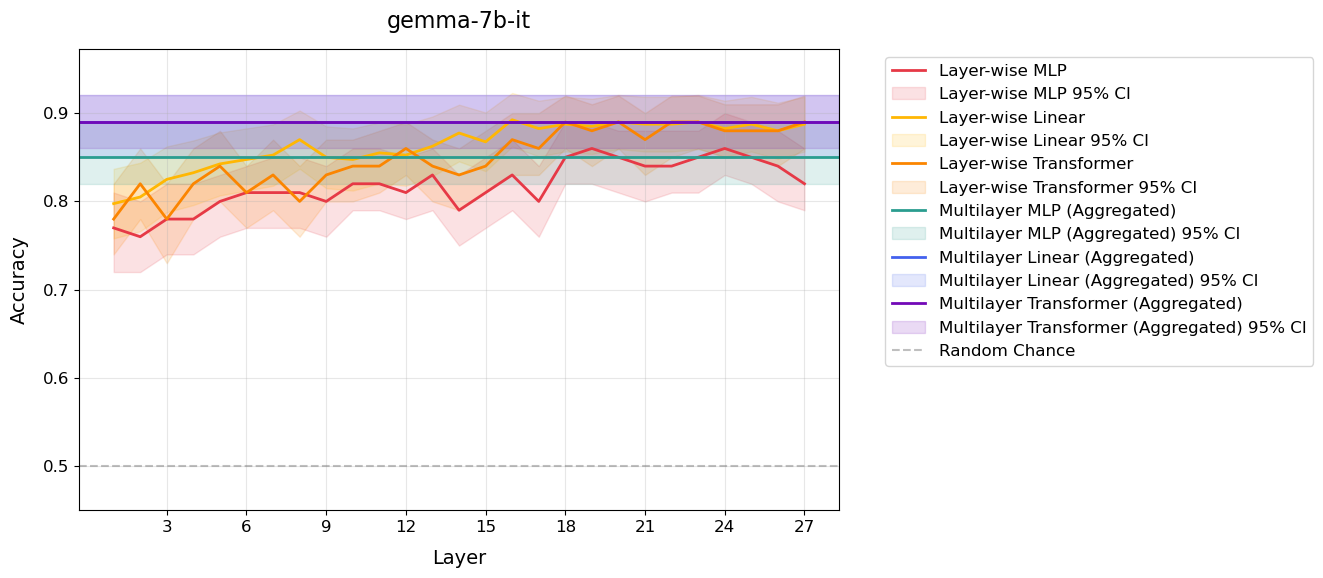

In [34]:
probe_data = {
    'Layer-wise MLP': {
        'type': 'layer-wise',
        'accuracies': mlp_accuracies,
        'cis': mlp_ci,
        'color': '#E63946'  # Bright red
    },
    'Layer-wise Linear': {
        'type': 'layer-wise',
        'accuracies': linear_accuracies,
        'cis': linear_ci,
        'color': '#FFB703'  # Golden yellow
    },
    'Layer-wise Transformer': {
        'type': 'layer-wise',
        'accuracies': transformer_accuracies,
        'cis': transformer_ci,
        'color': '#FB8500'  # Bright orange
    },
    'Multilayer MLP (Aggregated)': {
        'type': 'multilayer',
        'accuracies': multilayer_mlp_accuracy_aggregated,
        'cis': multilayer_mlp_ci_aggregated,
        'color': '#2A9D8F'  # Turquoise
    },
    'Multilayer Linear (Aggregated)': {
        'type': 'multilayer',
        'accuracies': multilayer_linear_accuracy_aggregated,
        'cis': multilayer_linear_ci_aggregated,
        'color': '#4361EE'  # Bright blue
    },
    'Multilayer Transformer (Aggregated)': {
        'type': 'multilayer',
        'accuracies': multilayer_trans_accuracy_aggregated,
        'cis': multilayer_trans_ci_aggregated,
        'color': '#7209B7'  # Purple
    }
}

save_path = project_root / f"images/accuracy_by_layer/{model_name}/{model_name}_probe_comparison_layerwise_multilayer_aggregated_probes.pdf"
plot_probe_comparison(layers, probe_data, model_name=model_name, save_path=save_path)